# CD4 Cropseq 2D Analysis

- Hyperparameter check
- Select genes to check correlation against
- Save the preprocessed AnnData object

In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import scipy.stats as stats
from pybedtools import BedTool
import pickle as pkl
%matplotlib inline
import itertools
import scipy.spatial.distance as dist

import statsmodels.formula.api as smf
import statsmodels.api as sm
pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 600)

In [2]:
import functools

In [3]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.9-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq')
import encode
import memento

In [4]:
data_path = '/data_volume/memento/tfko140/'
# fig_path = '/data/home/Github/scrna-parameter-estimation/figures/fig6/'

In [5]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [6]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'large',
         'xtick.labelsize':'xx-small',
         'ytick.labelsize':'xx-small'}
pylab.rcParams.update(params)

### Read the AnnData object

In [7]:
adata = sc.read(data_path + 'tfko.sng.guides.full.ct.h5ad')

Only considering the two last: ['.ct', '.h5ad'].
Only considering the two last: ['.ct', '.h5ad'].


In [8]:
adata.obs['guide1_cov'] = adata.obs['guide1_cov'].str.split('.').str[:-1].str.join('.')

### Pick out guides to test

In [9]:
counts = adata[adata.obs.WT == 'F'].obs.guide1_cov.value_counts()
filtered_guides = counts[counts > 500].index.tolist()

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


In [10]:
wt_guides = adata[adata.obs.WT == 'T'].obs.guide1_cov.drop_duplicates().tolist()

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


In [11]:
filtered_guides = list(set(filtered_guides) - set(wt_guides))

In [12]:
len(filtered_guides)

145

### Filter guides by ChIP-seq availability

In [13]:
tfs = [guide.split('.')[0] for guide in filtered_guides]

In [14]:
encode_meta = pd.read_csv('encode_tf/metadata.tsv', sep='\t', header=0)
encode_files = pd.read_csv('encode_tf/files.txt', sep='\t', header=None)

encode_meta = encode_meta[encode_meta['Output type'].isin([ 'IDR thresholded peaks', 'optimal IDR thresholded peaks']) & (encode_meta['File assembly'] == 'GRCh38')]
encode_meta['target'] = encode_meta['Experiment target'].str.split('-').str[0]
encode_meta = encode_meta.sort_values('Output type', ascending=False).drop_duplicates('target').query('target in @tfs')
encode_meta = encode_meta[encode_meta['Audit ERROR'].isnull()]
encode_tfs = encode_meta.target.tolist()

In [15]:
filtered_guides = [g for g in filtered_guides if g.split('.')[0] in encode_tfs]

In [16]:
enc = encode.Encode('/home/ssm-user/Github/misc-seq/miscseq/GRCh38Genes.bed')

### Setup memento

In [17]:
adata.obs['q'] = 0.11

In [18]:
memento.setup_memento(adata, q_column='q', trim_percent=0.1, shrinkage=0)

### Get differential expression result

In [19]:
result_1d = pd.read_csv(data_path + '1d/filtered_1d_result.csv').query('de_fdr < 0.1')

In [20]:
de_genes = {}
de_genes_by_gene = {}
results = {}
all_de_genes = set([])
for guide in filtered_guides:
    
    res = result_1d.query('tx == "{}"'.format(guide))
    de_genes[guide] = res.gene.tolist()
    results[guide] =res
    all_de_genes |= set(de_genes[guide])

### Get a list of (TF, TF's DEG) pairs

In [21]:
tf_gene_pairs = []

for guide in filtered_guides:
    
    tf = guide.split('.')[0]
        
    tf_gene_pairs += list(itertools.product([tf], de_genes[guide]))

In [22]:
len(tf_gene_pairs)

14095

### Run one sample correlation in WT

In [ ]:
adata.obs.donor.value_counts()

In [ ]:
for g in filtered_guides:
    if 'STAT1' in g:
        print(g)

In [ ]:
selected_guide = 'STAT1.190997935'

In [ ]:
%%time
# Do a one sample test for WT
adata_one_sample = adata[adata.obs.WT == "T"].copy().copy()
memento.create_groups(adata_one_sample, label_columns=['donor'])
memento.compute_1d_moments(adata_one_sample, min_perc_group=.8)

meta_df = memento.get_groups(adata_one_sample)
treatment = pd.DataFrame(np.ones((meta_df.shape[0], 1)))
covariate = pd.DataFrame(np.ones((meta_df.shape[0], 1)))

available_tf_gene_pairs = [(a,b) for a,b in tf_gene_pairs if a in adata_one_sample.var.index and b in adata_one_sample.var.index]
memento.compute_2d_moments(adata_one_sample, available_tf_gene_pairs)

memento.ht_2d_moments(
        adata_one_sample, 
        covariate=covariate,
        treatment=treatment, 
        num_boot=10000, 
        verbose=1,
        num_cpus=90,
        resampling='bootstrap',
        resample_rep=False,
        approx=False)
one_sample_result = memento.get_2d_ht_result(adata_one_sample)
one_sample_result.to_csv(data_path +'2d/wt_one_sample.csv', index=False)

### Get differential correlation result

In [43]:
selected_one_sample_result = pd.read_csv(data_path +'2d/wt_one_sample.csv')#.query('gene_2 in @downstream_genes').copy()
selected_one_sample_result['corr_fdr'] = memento.util._fdrcorrect(selected_one_sample_result['corr_pval'])

In [44]:
filtered_gene_pairs = selected_one_sample_result.query('corr_fdr < 0.1 & corr_coef > 0.1')
filtered_gene_pairs = list(zip(filtered_gene_pairs['gene_1'], filtered_gene_pairs['gene_2']))

In [ ]:
# adata_test = adata[adata.obs.donor.isin(['IGTB1840', 'IGTB884', 'IGTB2065'])].copy().copy()
adata_test = adata.copy().copy()

memento.create_groups(adata_test, label_columns=['guide1_cov'])
memento.compute_1d_moments(adata_test, min_perc_group=.7)
meta_df = memento.get_groups(adata_test)
meta_df = pd.get_dummies(meta_df, prefix='', prefix_sep='', drop_first=False)

treatment = meta_df[filtered_guides]
covariate = pd.DataFrame(np.ones((treatment.shape[0], 1)), columns=['intercept'])
# covariate = meta_df.iloc[:, -9:]

available_tf_gene_pairs = list(set([(a,b) for a,b in filtered_gene_pairs if a in adata_test.var.index and b in adata_test.var.index]))
memento.compute_2d_moments(adata_test, available_tf_gene_pairs)

#2:49 start
memento.ht_2d_moments(
        adata_test, 
        covariate=covariate,
        treatment=treatment,
        treatment_for_gene={pair:[tx for tx in treatment.columns if pair[1] in de_genes[tx]] for pair in available_tf_gene_pairs},
        num_boot=10000, 
        verbose=1,
        num_cpus=90,
        resampling='bootstrap',
        resample_rep=False,
        approx=False)
adata_test.write(data_path + '2d/dc.h5ad')

In [ ]:
memento.get_2d_ht_result(adata_test).to_csv(data_path + '2d/guide_combine_donor.csv', index=False)

### Draw networks

In [78]:
heatmap = pd.read_csv(data_path + '1d/raw_1d_result.csv')
heatmap['tf'] = heatmap['tx'].str.split('.').str[0]

In [79]:
heatmap = heatmap.pivot_table('de_coef', 'tf', 'gene')

In [80]:
cg = sns.clustermap(heatmap);
plt.close();
tfs = heatmap.index[cg.dendrogram_row.reordered_ind]
genes = heatmap.columns[cg.dendrogram_col.reordered_ind]

de_tfs = [tf for tf, gene in tf_gene_pairs]
de_genes = [gene for tf, gene in tf_gene_pairs]

tfs = [tf for tf in tfs if tf in de_tfs]
genes = [gene for gene in genes if gene in de_genes]

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


In [81]:
nodes = list(tfs)+list(genes)

In [82]:
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(tf_gene_pairs)

In [121]:
tf_positions = dict(zip(tfs, zip(np.linspace(-.9,0.9, len(tfs)), np.ones(len(tfs))     )))
positions = dict(zip(genes, zip(np.linspace(-1,1, len(genes)), np.random.random(len(genes))/100          )       ))
positions.update(tf_positions)

In [102]:
result_2d = pd.read_csv(data_path + '2d/guide_combine_donor.csv')

In [105]:
result_2d['corr_fdr'] = result_2d.groupby(['gene_1', 'tx'])['corr_pval'].transform(lambda x: memento.util._fdrcorrect(x))

In [109]:
sig_interactions = result_2d.query('corr_fdr < 0.1')#.head(5)

In [166]:
IG = G.copy()

In [167]:
inodes = []
for idx, row in sig_interactions.iterrows():
    
    tf_ko = row['tx'].split('.')[0]
    tf = row['gene_1']
    gene = row['gene_2']
    
    if (tf_ko, gene) in IG.edges():
        IG.remove_edge(tf_ko, gene)
    if (tf, gene) in IG.edges():
        IG.remove_edge(tf, gene)
    inode = tf_ko + '+'+ tf
    IG.add_node(inode)
    IG.add_edge(tf, inode)
    IG.add_edge(tf_ko, inode)
    IG.add_edge(inode, gene)
    inodes.append(inode)
    

In [214]:
inode_positions = dict(zip(inodes, zip     (     stats.uniform.rvs(-1, 2., len(inodes)),    np.random.random(len(inodes))/10+0.5     )))
IG_positions = positions.copy()
IG_positions.update(inode_positions)

In [259]:
sns_pal = 'colorblind'

tf_color='black'
inode_color='teal'
interact_color='darkgreen'

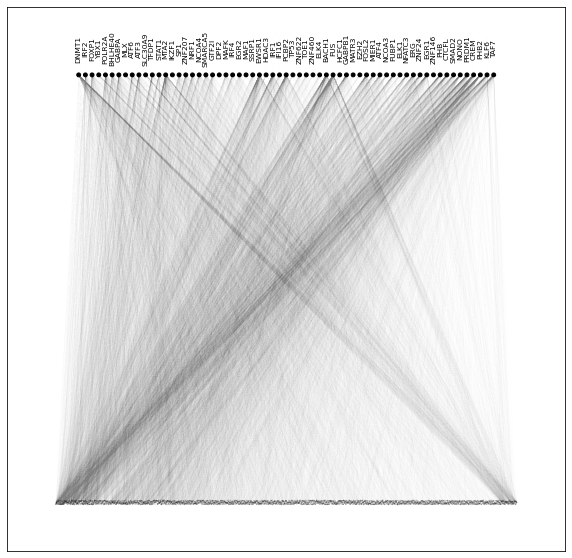

In [260]:
# pos = nx.circular_layout(G)
plt.figure(figsize=(10,10))

nx.draw_networkx(
    G, 
    pos=positions, 
    with_labels=False, 
    node_size=[15 if n in tfs else 0.01 for n in G.nodes()] ,
    width=0.003, 
    node_color=[tf_color if n in tfs else 'black' for n in G.nodes() ],
    edge_color='grey')
text = nx.draw_networkx_labels(
    G, 
    pos={node:[pos[0], pos[1]+.06] for node,pos in positions.items()}, 
    labels={tf:tf for tf in tfs})
for _,t in text.items():
    t.set_rotation('vertical')
    t.set_fontsize(7.5)
plt.savefig('de_graph.png', dpi=100, bbox_inches='tight')

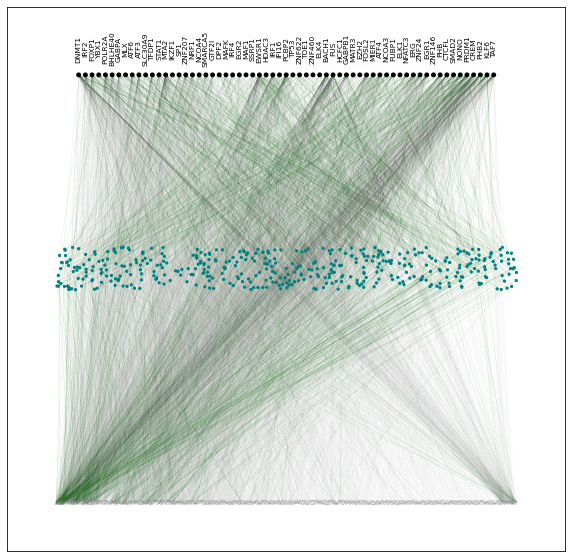

In [261]:
plt.figure(figsize=(10,10))
nx.draw_networkx(
    IG, 
    pos=IG_positions, 
    with_labels=False, 
    node_size=[15 if n in tfs else (5 if n in inodes else 0.01) for n in IG.nodes()] ,
    width=[.05 if u in inodes or v in inodes else 0.003 for u,v in IG.edges()], 
    node_color=[tf_color if n in tfs else (inode_color if n in inodes else 'grey') for n in IG.nodes() ],
    edge_color=[interact_color if u in inodes or v in inodes else 'grey' for u,v in IG.edges()])
text = nx.draw_networkx_labels(
    IG, 
    pos={node:[pos[0], pos[1]+.06] for node,pos in IG_positions.items()}, 
    labels={tf:tf for tf in tfs})
for _,t in text.items():
    t.set_rotation('vertical')
    t.set_fontsize(7.5)
plt.savefig('interact_graph.png', dpi=100, bbox_inches='tight')

In [87]:
tfg = {frozenset(pair):[tx for tx in treatment.columns if pair[1] in de_genes[tx]] for pair in available_tf_gene_pairs}
num_tests = 0
for k,v in tfg.items():
    num_tests += len(v)

In [88]:
num_tests

32333

In [86]:
len(tfg)

3348

In [83]:
result_df = []
for pair in adata_test.uns['memento']['2d_moments']['gene_pairs']:
    if len(adata_test.uns['memento']['2d_ht']['treatment_for_gene'][frozenset(pair)]) == 0:
        continue
    temp = pd.DataFrame([pair for i in range(len(adata_test.uns['memento']['2d_ht']['treatment_for_gene'][frozenset(pair)]))], columns=['gene_1', 'gene_2'])
    temp['tx'] = adata_test.uns['memento']['2d_ht']['treatment_for_gene'][frozenset(pair)]
    result_df.append(temp)
result_df = pd.concat(result_df)

In [84]:
len(result_df)

32345

In [82]:
len(adata_test.uns['memento']['2d_ht']['treatment_for_gene'])

3348

In [80]:
len(adata_test.uns['memento']['2d_moments']['gene_pairs'])

3349

In [79]:
len(set(adata_test.uns['memento']['2d_moments']['gene_pairs']))

3349

In [69]:
num_tests

32333

In [70]:
result_df = pd.concat([
    pd.DataFrame(itertools.product([pair], adata_test.uns['memento']['2d_ht']['treatment_for_gene'][frozenset(pair)]), 
        columns=['pair', 'tx']) for pair in adata_test.uns['memento']['2d_moments']['gene_pairs']])

In [71]:
len(result_df)

32345

In [65]:
def get_2d_ht_result(adata):
    """
        Getter function for 2d HT result
    """
    if 'treatment_for_gene' in adata.uns['memento']['2d_ht']:
        result_df = []
        for pair in adata_test.uns['memento']['2d_moments']['gene_pairs']:
            temp = pd.DataFrame([pair for i in range(len(adata_test.uns['memento']['2d_ht']['treatment_for_gene'][frozenset(pair)]))], columns=['gene_1', 'gene_2'])
            temp['tx'] = adata_test.uns['memento']['2d_ht']['treatment_for_gene'][frozenset(pair)]
            result_df.append(temp)
        result_df = pd.concat(result_df)
    else:
        result_df = pd.DataFrame(itertools.product(adata.uns['memento']['2d_moments']['gene_pairs'], adata.uns['memento']['2d_ht']['treatment'].columns), 
                columns=['pair', 'tx'])
        result_df = pd.concat([pd.DataFrame(result_df['pair'].tolist(), columns=['gene_1', 'gene_2']), result_df[['tx']].reset_index(drop=True)], axis=1)
    result_df['corr_coef'] = adata.uns['memento']['2d_ht']['corr_coef']
    result_df['corr_se'] = adata.uns['memento']['2d_ht']['corr_se']
    result_df['corr_pval'] = adata.uns['memento']['2d_ht']['corr_asl']

    return result_df

In [66]:
get_2d_ht_result(adata_test).to_csv(data_path + '2d/guide_combine_donor.csv', index=False)

ValueError: Length of values (32333) does not match length of index (32345)

In [28]:
tfg = {frozenset(pair):[tx for tx in treatment.columns if pair[1] in de_genes[tx]] for pair in available_tf_gene_pairs}

In [30]:
treatment.shape[1]

84

In [34]:
treatment[tfg[frozenset(('PHB', 'TPM4'))]].shape

(280, 21)

In [37]:
len(tfg)

3348

In [35]:
len(available_tf_gene_pairs)

3402

In [36]:
len(set(available_tf_gene_pairs))

3349

In [31]:
for pair in available_tf_gene_pairs:
    
    if len(tfg[frozenset(pair)]) == 21:
        print(pair)

('PHB', 'TPM4')
('FUS', 'H2AFZ')
('FUS', 'POMP')
('FUS', 'KIAA0101')
('FUBP1', 'PTPRCAP')
('MLX', 'H2AFZ')
('MLX', 'COX8A')
('PRDM1', 'MALAT1')
('NFATC3', 'ENO1')
('NFATC3', 'COX8A')
('NFATC3', 'KIAA0101')
('NFATC3', 'TPM4')
('NCOA4', 'CHCHD2')
('NONO', 'C6orf48')
('NONO', 'CHCHD2')
('GABPB1', 'CHCHD2')
('MIER1', 'ENO1')
('PHB2', 'CHCHD2')
('PHB2', 'KIAA0101')
('PHB2', 'MT-ND4L')
('GABPA', 'H2AFZ')
('STAT1', 'ENO1')
('STAT1', 'H2AFZ')
('STAT1', 'MALAT1')
('STAT1', 'KIAA0101')
('STAT1', 'TPM4')
('EWSR1', 'H2AFZ')
('EWSR1', 'CHCHD2')
('EWSR1', 'TPM4')
('MIER1', 'PTPRCAP')
('SMARCA5', 'MT-ND4L')
('PHB', 'ENO1')
('PHB', 'CHCHD2')
('PHB', 'COX8A')
('NONO', 'MT-ND4L')
('PCBP2', 'MALAT1')
('ZNF207', 'CFL1')
('EWSR1', 'CHCHD2')
('EWSR1', 'TPM4')
('PRDM1', 'MALAT1')
('ZNF24', 'TPM4')
('TFDP1', 'H2AFZ')
('TFDP1', 'CHCHD2')
('TFDP1', 'MALAT1')
('TFDP1', 'KIAA0101')
('KLF6', 'ENO1')
('KLF6', 'COX8A')
('KLF6', 'CFL1')
('KLF6', 'POMP')
('DNMT1', 'C6orf48')
('DNMT1', 'MALAT1')
('DNMT1', 'CFL1')
('DNM

In [29]:
tfg[frozenset(('IRF1', 'TNFRSF14'))]

['PRDM1.106105284',
 'PRDM1.106088300',
 'TAF7.141319508',
 'IRF1.132487047',
 'FOSL2.28408792',
 'IRF1.132487119',
 'PCBP2.53455366',
 'POLR2A.7498096',
 'YBX1.42696671',
 'EGR1.138467317',
 'IRF2.184418577']

In [27]:
available_tf_gene_pairs

[('IRF1', 'TNFRSF14'),
 ('IRF1', 'ODF2L'),
 ('IRF1', 'GBP1'),
 ('IRF1', 'GBP2'),
 ('IRF1', 'GBP4'),
 ('IRF1', 'GBP5'),
 ('IRF1', 'TXNIP'),
 ('IRF1', 'GUK1'),
 ('IRF1', 'VAMP5'),
 ('IRF1', 'COX5B'),
 ('IRF1', 'GPR155'),
 ('IRF1', 'ITGA4'),
 ('IRF1', 'STAT1'),
 ('IRF1', 'SP100'),
 ('IRF1', 'MANF'),
 ('IRF1', 'PARP14'),
 ('IRF1', 'ERAP2'),
 ('IRF1', 'ATOX1'),
 ('IRF1', 'CYFIP2'),
 ('IRF1', 'BTN3A2'),
 ('IRF1', 'HLA-A'),
 ('IRF1', 'HLA-C'),
 ('IRF1', 'HLA-B'),
 ('IRF1', 'PSMB8'),
 ('IRF1', 'PSMB9'),
 ('IRF1', 'TAPBP'),
 ('IRF1', 'RNASET2'),
 ('IRF1', 'SAMD9L'),
 ('IRF1', 'BUD31'),
 ('IRF1', 'MKRN1'),
 ('IRF1', 'LY6E'),
 ('IRF1', 'OPTN'),
 ('IRF1', 'IFITM2'),
 ('IRF1', 'IFITM1'),
 ('IRF1', 'UBE2L6'),
 ('IRF1', 'RARRES3'),
 ('IRF1', 'DRAP1'),
 ('IRF1', 'CASP4'),
 ('IRF1', 'FKBP11'),
 ('IRF1', 'PA2G4'),
 ('IRF1', 'N4BP2L2'),
 ('IRF1', 'EPSTI1'),
 ('IRF1', 'ITM2B'),
 ('IRF1', 'PSME1'),
 ('IRF1', 'PSME2'),
 ('IRF1', 'RTF1'),
 ('IRF1', 'PDIA3'),
 ('IRF1', 'NDUFB10'),
 ('IRF1', 'PSMB10'),
 ('IRF1

In [ ]:
memento.get_2d_ht_result(adata_test).to_csv(data_path + '2d/guide_combine_donor.csv', index=False)

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/home/ss

In [118]:
two_sample_result = memento.get_2d_ht_result(adata_test)
two_sample_result['corr_fdr'] = memento.util._fdrcorrect(two_sample_result['corr_pval'])

In [120]:
guide_combine_donor = two_sample_result.sort_values('corr_pval').copy()

In [130]:
combine_guide_combine_donor['corr_fdr'] = combine_guide_combine_donor.groupby('gene_1')['corr_pval'].transform(lambda x: memento.util._fdrcorrect(x))

In [133]:
combine_guide_combine_donor.query('corr_fdr < 0.15')

,gene_1,gene_2,tx,corr_coef,corr_se,corr_pval,corr_fdr
455,PCBP2,TMBIM6,ko,-0.224709,0.066264,0.001200,0.028797
298,SNW1,NKG7,ko,-0.185066,0.059326,0.002000,0.035996
450,PCBP2,CHCHD2,ko,-0.245876,0.080107,0.002700,0.032397
377,ARID5B,DUT,ko,-0.139979,0.047099,0.004500,0.013499
454,PCBP2,MALAT1,ko,-0.228911,0.071511,0.005399,0.043196
371,SRA1,ACTB,ko,0.241507,0.099310,0.008499,0.033997
32,PHB,NUDT1,ko,0.241353,0.093956,0.010099,0.141386
530,YBX1,COX6A1,ko,-0.240090,0.085543,0.010699,0.074893
449,PCBP2,LSM5,ko,-0.182166,0.071419,0.012999,0.077992
443,MATR3,MT2A,ko,-0.169060,0.072014,0.019798,0.039596


In [ ]:
combine_guide_donor

In [124]:
combine_guide_combine_donor.head(5)

,gene_1,gene_2,tx,corr_coef,corr_se,corr_pval,corr_fdr
455,PCBP2,TMBIM6,ko,-0.224709,0.066264,0.001200,0.494951
298,SNW1,NKG7,ko,-0.185066,0.059326,0.002000,0.494951
450,PCBP2,CHCHD2,ko,-0.245876,0.080107,0.002700,0.494951
377,ARID5B,DUT,ko,-0.139979,0.047099,0.004500,0.593941
454,PCBP2,MALAT1,ko,-0.228911,0.071511,0.005399,0.593941


(array([64., 69., 62., 55., 56., 50., 45., 45., 51., 53.]),
 array([0.00119988, 0.1010299 , 0.20085991, 0.30068993, 0.40051995,
        0.50034997, 0.60017998, 0.70001   , 0.79984002, 0.89967003,
        0.99950005]),
 <BarContainer object of 10 artists>)

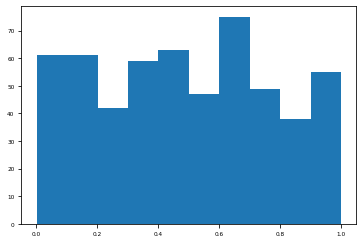

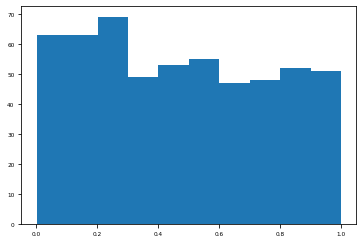

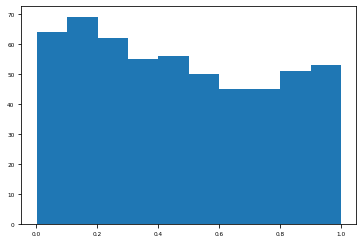

In [123]:
plt.figure()
plt.hist(combine_guide_donor['corr_pval'])
plt.figure()

plt.hist(guide_combine_donor['corr_pval'])
plt.figure()

plt.hist(combine_guide_combine_donor['corr_pval'])

In [ ]:
plt.hist(combine_guide_donor['corr_pval'])

In [99]:
# combine_guide_donor = two_sample_result.sort_values('corr_pval').copy()
# combine_guide_combine_donor = two_sample_result.sort_values('corr_pval').copy()
guide_combine_donor = two_sample_result.sort_values('corr_pval').copy()

<AxesSubplot:xlabel='corr_coef', ylabel='Density'>

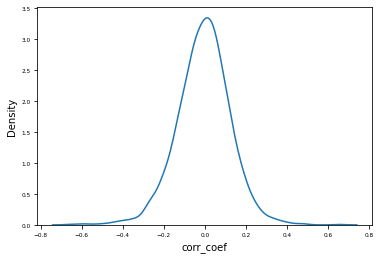

In [55]:
sns.kdeplot(memento.get_2d_ht_result(adata_test).sort_values('corr_pval').corr_coef)

In [56]:
donor_combine_guides = memento.get_2d_ht_result(adata_test).sort_values('corr_pval').dropna()

In [57]:
donor_combine_guides

,gene_1,gene_2,tx,corr_coef,corr_se,corr_pval
1207,BACH1,EBP,ko,-0.615297,0.119860,0.000699
477,NONO,SLC25A5,ko,-0.571204,0.137533,0.001098
2113,SLC30A9,CENPW,ko,-0.399986,0.101843,0.001099
30,SATB1,GMNN,ko,-0.311304,0.080956,0.001248
1218,BACH1,FAM111A,ko,-0.301072,0.085546,0.001300
...,...,...,...,...,...,...
1739,ZNF593,GOLGB1,ko,0.000421,0.156891,0.998000
476,NONO,CHCHD2,ko,0.000358,0.097713,0.998700
106,ID2,TPM3,ko,-0.000162,0.070468,0.998800
1422,ELK4,CALM1,ko,-0.000099,0.088337,0.999300


In [ ]:
plt.hist(df['corr_pval'])

In [ ]:
for g in filtered_guides:
        
    adata_ko = adata.copy()[adata.obs.guide1_cov.isin([g]) | (adata.obs.WT =='T')].copy()

    adata_ko.obs['ko_indicator'] = (adata_ko.obs['guide1_cov']==g).astype(int)
#     adata_ko.obs['ko_indicator'] = np.random.choice(2, adata_ko.shape[0])

    memento.create_groups(adata_ko, label_columns=['ko_indicator'])
    memento.compute_1d_moments(adata_ko, min_perc_group=.7)
    
    available_tf_gene_pairs = [(a,b) for a,b in tf_gene_pairs if a in adata_ko.var.index and b in adata_ko.var.index]
    memento.compute_2d_moments(adata_ko, available_tf_gene_pairs)
    
    meta_df = memento.get_groups(adata_ko)
    meta_df = pd.get_dummies(meta_df, drop_first=True)
    
    meta_df['intercept'] = 1
    treatment = meta_df[['ko_indicator']].copy()
#     covariate = meta_df.iloc[:, 1:].copy()
    covariate = meta_df[['intercept']]
#     for col in covariate.columns:
#         covariate['x_'+col] = treatment['ko_indicator']*covariate[col]

    memento.ht_2d_moments(
        adata_ko, 
        covariate=covariate,
        treatment=treatment, 
        num_boot=0, 
        verbose=1,
        num_cpus=90,
        resampling='bootstrap',
        resample_rep=False,
        approx=False)
    res =  memento.get_2d_ht_result(adata_ko)
    
    res.to_csv(data_path + '2d_tests/{}_es_only.csv'.format(g), index=False)
    
    break

### For each guide, find TFs with significantly altered TF-gene relationships

In [ ]:
combined_result = {}
for g in filtered_guides:

    res = pd.read_csv(data_path + '2d_tests/{}.csv'.format(g))
    res['corr_fdr'] = memento.util._fdrcorrect(res['corr_pval'])
    combined = res.groupby('gene_1').corr_pval.apply(lambda x: stats.combine_pvalues(x)[1])
    combined_result[g] = combined

combined_result = pd.DataFrame(combined_result)#.dropna(axis=0, how='all').fillna(1)
sorted_columns = np.sort(combined_result.columns)
combined_result = combined_result[sorted_columns]

In [33]:
all_pvs = combined_result.values.reshape(-1)
all_fdr = memento.util._fdrcorrect(all_pvs)

In [34]:
combined_result.loc[:,:] = all_fdr.reshape(combined_result.shape)
combined_result = combined_result.fillna(1)

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


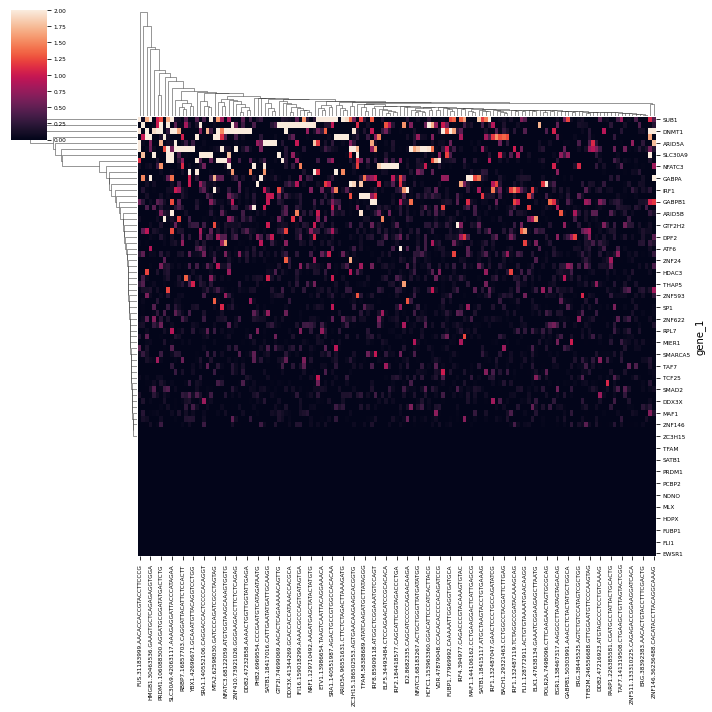

In [35]:
cg = sns.clustermap(-np.log10(combined_result), vmax=2);
gene_order = cg.dendrogram_row.reordered_ind
guide_order = cg.dendrogram_col.reordered_ind

In [36]:
combined_result = combined_result.iloc[gene_order, guide_order]

In [37]:
def get_interacting_genes(tf, thresh=0.05):
    print(tf)
    for g in combined_result.loc[tf][combined_result.loc[tf] < 0.05].index:
        print(g.split('.')[0])

In [38]:
get_interacting_genes('STAT1')

STAT1


<AxesSubplot:ylabel='gene_1'>

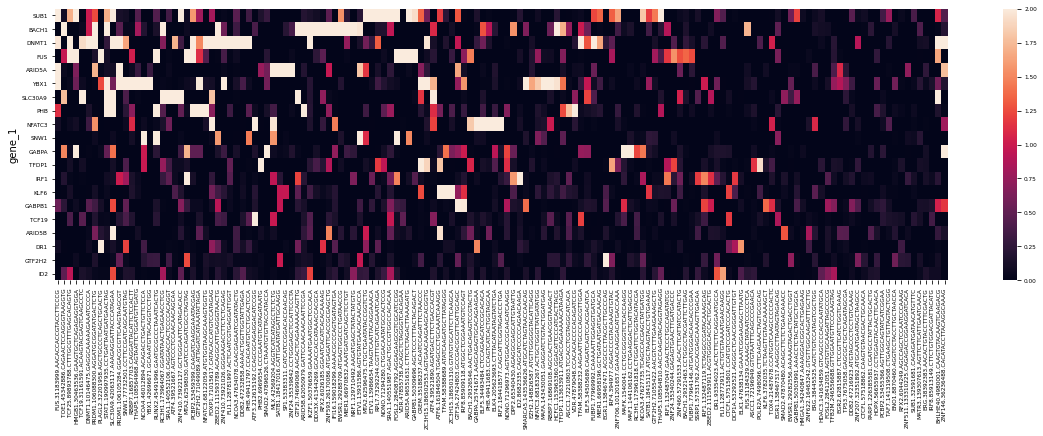

In [173]:
plt.figure(figsize=(20,5))
sns.heatmap(-np.log10(combined_result.iloc[:20]), vmax=2)

<AxesSubplot:ylabel='gene_1'>

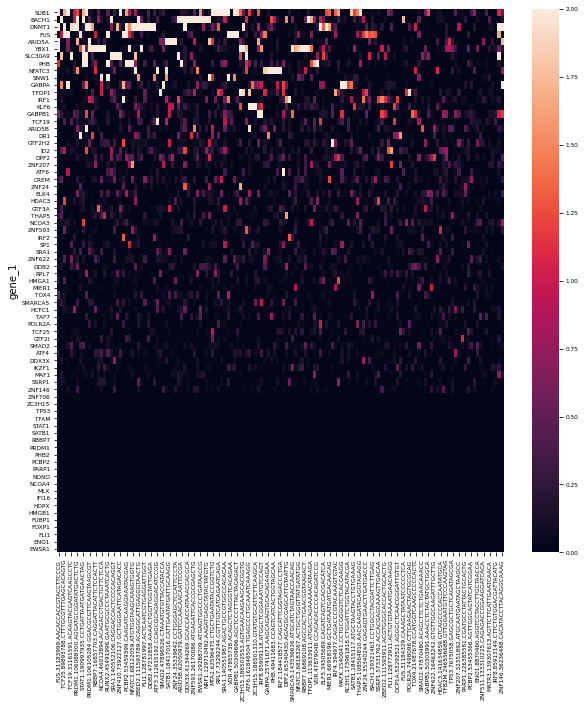

In [174]:
plt.figure(figsize=(10,10))
sns.heatmap(-np.log10(combined_result), vmax=2)

### ChIP-seq analysis

If this doesnt work, try HOMER

In [52]:
tfs = [guide.split('.')[0] for guide in filtered_guides]

In [53]:
encode_meta = pd.read_csv('encode_tf/metadata.tsv', sep='\t', header=0)
encode_files = pd.read_csv('encode_tf/files.txt', sep='\t', header=None)

encode_meta = encode_meta[encode_meta['Output type'].isin([ 'IDR thresholded peaks', 'optimal IDR thresholded peaks']) & (encode_meta['File assembly'] == 'GRCh38')]
encode_meta['target'] = encode_meta['Experiment target'].str.split('-').str[0]
encode_meta = encode_meta.sort_values('Output type', ascending=False).drop_duplicates('target').query('target in @tfs')
encode_meta = encode_meta[encode_meta['Audit ERROR'].isnull()]

In [54]:
enc = encode.Encode('/home/ssm-user/Github/misc-seq/miscseq/GRCh38Genes.bed')

In [58]:
# encode_result = {}

# for idx, row in encode_meta.iterrows():
    
#     url = row['File download URL']
#     genes = enc.get_peak_genes_encode(url, 0)
#     encode_result[row['target']] = genes.query('distance >= 0').copy()

In [57]:
# with open('encode_result.pkl', 'wb') as f:
#     pkl.dump(encode_result, f)

In [60]:
colocalization_df = []
for guide, tf in itertools.product(combined_result.columns, combined_result.index):

    guide_target = guide.split('.')[0]
    if guide_target not in encode_meta.target.tolist() or tf not in encode_meta.target.tolist():
        continue
    fdr = combined_result.loc[tf, guide]

    merged = encode_result[guide_target].merge(encode_result[tf], on='gene')
    
    for distance in [10, 50, 100, 500, 1000, 5000, 10000, 20000]:
        degs = de_genes[guide]
        colocal_count = merged.query('distance_x < {} & distance_y < {} & gene in @degs'.format(distance, distance)).shape[0]
        if fdr < 0.1:
            colocalization_df.append(('DC', colocal_count, distance))
        else:
            colocalization_df.append(('nonsig', colocal_count, distance))

In [61]:
colocalization_df = pd.DataFrame(colocalization_df, columns=['category', 'count', 'window'])

In [62]:
colocalization_df['window'] = colocalization_df['window'].astype(str)

<AxesSubplot:xlabel='window', ylabel='count'>

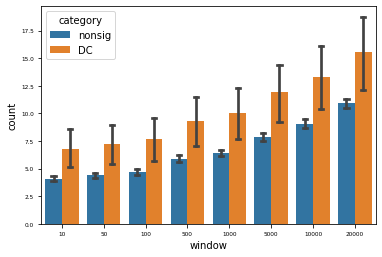

In [63]:
sns.barplot(x='window', y='count', hue='category', data=colocalization_df, ci=68, capsize=0.1)

### Annotate with CORUM data

In [43]:
complexes_df = pd.read_csv('allComplexes.txt', sep='\t').query('Organism == "Human"')

In [44]:
complexes_df.shape

(2916, 20)

In [45]:
targeted_genes = list(set([guide.split('.')[0] for guide in filtered_guides]))

In [46]:
components_list = complexes_df['subunits(Gene name)'].str.split(';').tolist()

In [47]:
tf_pairs = pd.DataFrame([(x,y) for x,y in itertools.combinations(targeted_genes, 2)], columns=['tf1', 'tf2'])

In [48]:
is_complexed = []
for idx, row in tf_pairs.iterrows():
    if idx % 1000 == 0:
        print(idx)
    complex_found = False
    for subunits in components_list:
        if row['tf1'] in subunits and row['tf2'] in subunits:
            complex_found = True
            break
    is_complexed.append(complex_found)
    

0
1000
2000
3000
4000
5000


In [49]:
tf_pairs['CORUM'] = is_complexed

In [50]:
tf_pairs.query('CORUM').head(5)

,tf1,tf2,CORUM
25,EWSR1,FUS,True
53,EWSR1,POLR2A,True
69,EWSR1,DDX3X,True
433,ELK1,FLI1,True
453,ELK1,ELK4,True


### Predict complexes with simple correlation of effect sizes

In [51]:
mean_lfc_corr = []
mean_lfc_corr_pv = []

for idx, row in tf_pairs.iterrows():
    
    tf1, tf2 = row['tf1'], row['tf2']
    
    tf1_guides = [g for g in filtered_guides if tf1 in g]
    tf2_guides = [g for g in filtered_guides if tf2 in g]
    
    max_corr = -1
    max_corr_pv = 1
    
    for g1, g2 in itertools.product(tf1_guides, tf2_guides):
        
        tf1_df, tf2_df = results[g1], results[g2]
        merged = tf1_df.merge(tf2_df, on='gene')
        corr, pv = stats.pearsonr(merged['de_coef_x'], merged['de_coef_y'])
        if corr > max_corr:
            max_corr = corr
            max_corr_pv = pv
    mean_lfc_corr.append(max_corr)
    mean_lfc_corr_pv.append(max_corr_pv)

In [52]:
tf_pairs['mean_lfc_corr'] = mean_lfc_corr
tf_pairs['mean_lfc_corr_pv'] = mean_lfc_corr_pv

In [53]:
tf_pairs['mean_lfc_corr_pv_log10'] = -np.log10(np.array(mean_lfc_corr_pv)+1e-200)

<AxesSubplot:xlabel='CORUM', ylabel='mean_lfc_corr_pv_log10'>

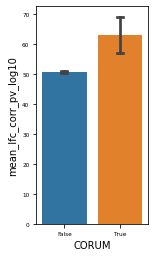

In [66]:
plt.figure(figsize=(2,4))
sns.barplot(x='CORUM', y='mean_lfc_corr_pv_log10', data=tf_pairs, ci=68, capsize=0.1)

### Predict complex with differential correlation

In [55]:
combined_result = {}
for g in filtered_guides:

    res = pd.read_csv(data_path + '2d_tests/{}.csv'.format(g))
    res['corr_fdr'] = memento.util._fdrcorrect(res['corr_pval'])
    combined = res.groupby('gene_1').corr_pval.apply(lambda x: stats.combine_pvalues(x)[1])
    combined_result[g] = combined

combined_result = pd.DataFrame(combined_result)#.dropna(axis=0, how='all').fillna(1)
sorted_columns = np.sort(combined_result.columns)
combined_result = combined_result[sorted_columns]

In [59]:
'ELK1' in combined_result.index

False

In [60]:
dc_pv = []

for idx, row in tf_pairs.iterrows():
    
    tf1, tf2 = row['tf1'], row['tf2']
    
    tf1_guides = [g for g in filtered_guides if tf1 in g]
    tf2_guides = [g for g in filtered_guides if tf2 in g]
    
    min_pv = 1
    invalid = True
    
    for tf, g in list(itertools.product([tf1], tf2_guides)) + list(itertools.product([tf2], tf1_guides)):
        
        if tf not in combined_result.index or g not in combined_result.columns:
            continue
        if combined_result.loc[tf, g] < min_pv:
            min_pv = combined_result.loc[tf, g]
            invalid=False
    if invalid:
        dc_pv.append(np.nan)
    else:
        dc_pv.append(min_pv)


In [61]:
tf_pairs['dc_pv'] = dc_pv
tf_pairs['dc_pv_log10'] = -np.log10(np.array(dc_pv))


In [62]:
tf_pairs

,tf1,tf2,CORUM,mean_lfc_corr,mean_lfc_corr_pv,mean_lfc_corr_pv_log10,dc_pv,dc_pv_log10
0,EWSR1,STAT1,False,0.151455,6.856960e-22,21.163868,NaN,NaN
1,EWSR1,VDR,False,0.197860,4.654340e-35,34.332142,NaN,NaN
2,EWSR1,ATF3,False,0.200337,5.943878e-36,35.225930,NaN,NaN
3,EWSR1,ELK1,False,0.159007,2.442735e-23,22.612124,NaN,NaN
4,EWSR1,MIER1,False,0.206819,1.447793e-37,36.839294,0.250184,0.601740
...,...,...,...,...,...,...,...,...
5560,SP1,ZNF593,False,0.253989,2.041662e-59,58.690016,0.241126,0.617756
5561,SP1,BHLHE40,False,0.248988,3.124168e-56,55.505266,0.734453,0.134036
5562,MTA2,ZNF593,False,0.299146,3.482578e-84,83.458099,0.125009,0.903059
5563,MTA2,BHLHE40,False,0.306360,1.876444e-86,85.726665,NaN,NaN


<AxesSubplot:xlabel='CORUM', ylabel='dc_pv_log10'>

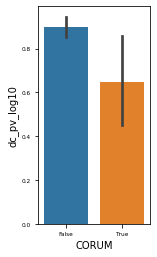

In [64]:
plt.figure(figsize=(2,4))
sns.barplot(x='CORUM', y='dc_pv_log10', data=tf_pairs,)

In [65]:
tf_pairs.query('CORUM')

,tf1,tf2,CORUM,mean_lfc_corr,mean_lfc_corr_pv,mean_lfc_corr_pv_log10,dc_pv,dc_pv_log10
25,EWSR1,FUS,True,0.166232,2.317199e-26,25.635037,0.530464,0.275344
53,EWSR1,POLR2A,True,0.193411,1.943260e-32,31.711469,0.184469,0.734076
69,EWSR1,DDX3X,True,0.203547,1.452515e-36,35.837879,0.850187,0.070486
433,ELK1,FLI1,True,0.310302,8.149487e-90,89.088870,NaN,NaN
453,ELK1,ELK4,True,0.264691,8.203592e-69,68.085996,0.978882,0.009270
1784,PHB,PHB2,True,1.000000,0.000000e+00,200.000000,0.942675,0.025638
2138,TAF7,HCFC1,True,0.197351,2.374258e-36,35.624472,0.076985,1.113596
2263,FLI1,ELK4,True,0.276019,3.292297e-70,69.482501,0.522211,0.282154
2448,FUS,DDX3X,True,0.328724,1.275108e-101,100.894453,0.071280,1.147034
2679,GTF2I,DDX3X,True,0.201691,9.404978e-37,36.026642,0.210761,0.676210


In [172]:
sig_counts

[]

In [170]:
colocal_count

NameError: name 'colocal_count' is not defined

In [99]:
encode_files

,0
0,https://www.encodeproject.org/files/ENCFF736FG...
1,https://www.encodeproject.org/files/ENCFF895MH...
2,https://www.encodeproject.org/files/ENCFF806TI...
3,https://www.encodeproject.org/files/ENCFF085GH...
4,https://www.encodeproject.org/files/ENCFF710YJ...
...,...
2593,https://www.encodeproject.org/files/ENCFF112GJ...
2594,https://www.encodeproject.org/files/ENCFF871ZO...
2595,https://www.encodeproject.org/files/ENCFF435SN...
2596,https://www.encodeproject.org/files/ENCFF737RZ...


In [91]:
encode_tfs = set(encode_info['Target gene symbol'].tolist())

In [92]:
filtered_tfs = list(set(tfs)&encode_tfs)

In [93]:
len(filtered_tfs)

70

In [94]:
encode_info.columns

Index(['ID', 'Accession', 'Assay name', 'Assay title', 'Target',
       'Target of assay', 'Target gene symbol', 'Biosample summary',
       'Biosample term name', 'Dbxrefs', 'Description', 'Lab', 'Project',
       'Status', 'Files', 'Related series', 'Biosample accession',
       'Biological replicate', 'Technical replicate', 'Linked antibody',
       'Organism', 'Life stage', 'Biosample age', 'Biosample treatment',
       'Biosample treatment ontology ID', 'Biosample treatment amount',
       'Biosample treatment amount units', 'Biosample treatment duration',
       'Biosample treatment duration units', 'Synchronization',
       'Post-synchronization time', 'Post-synchronization time units',
       'Biosample modification site target organism',
       'Biosample modification site introduced gene organism', 'Replicates',
       'Mixed biosamples', 'Cellular component',
       'Library construction platform', 'Library construction method'],
      dtype='object')

In [96]:
encode_info.head(5)

,ID,Accession,Assay name,Assay title,Target,Target of assay,Target gene symbol,Biosample summary,Biosample term name,Dbxrefs,Description,Lab,Project,Status,Files,Related series,Biosample accession,Biological replicate,Technical replicate,Linked antibody,Organism,Life stage,Biosample age,Biosample treatment,Biosample treatment ontology ID,Biosample treatment amount,Biosample treatment amount units,Biosample treatment duration,Biosample treatment duration units,Synchronization,Post-synchronization time,Post-synchronization time units,Biosample modification site target organism,Biosample modification site introduced gene organism,Replicates,Mixed biosamples,Cellular component,Library construction platform,Library construction method
0,/experiments/ENCSR935GZV/,ENCSR935GZV,ChIP-seq,TF ChIP-seq,/targets/NFYB-human/,NFYB,NFYB,Homo sapiens HepG2 genetically modified (inser...,HepG2,GEO:GSE170694,ChIP-Seq on HepG2,"Richard Myers, HAIB",ENCODE,released,"/files/ENCFF062IKU/,/files/ENCFF791UHQ/,/files...",NaN,"ENCBS471LWZ,ENCBS948CVC","2,1",1,ENCAB697XQW,Homo sapiens,child,15 years,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/organisms/human/,NaN,/replicates/93af5db9-f614-41cc-b8fd-d9c62ea35c...,NaN,NaN,NaN,NaN
1,/experiments/ENCSR915APT/,ENCSR915APT,ChIP-seq,TF ChIP-seq,/targets/ZCCHC11-human/,ZCCHC11,TUT4,Homo sapiens HepG2 genetically modified (inser...,HepG2,GEO:GSE170601,ChIP-Seq on HepG2,"Richard Myers, HAIB",ENCODE,released,"/files/ENCFF779WVZ/,/files/ENCFF693WHA/,/files...",NaN,"ENCBS159SFC,ENCBS491PEV","2,1",1,ENCAB697XQW,Homo sapiens,child,15 years,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/organisms/human/,NaN,/replicates/9dcde9a1-ea28-402b-b054-5feffe8fff...,NaN,NaN,NaN,NaN
2,/experiments/ENCSR956OSX/,ENCSR956OSX,ChIP-seq,TF ChIP-seq,/targets/ONECUT1-human/,ONECUT1,ONECUT1,Homo sapiens HepG2 genetically modified (inser...,HepG2,GEO:GSE170781,ChIP-Seq on HepG2,"Richard Myers, HAIB",ENCODE,released,"/files/ENCFF218KXL/,/files/ENCFF843QCN/,/files...",NaN,"ENCBS005EKG,ENCBS988CVN","1,2",1,ENCAB697XQW,Homo sapiens,child,15 years,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/organisms/human/,NaN,/replicates/9500e95f-e4ff-42ca-bab8-4216f067fc...,NaN,NaN,NaN,NaN
3,/experiments/ENCSR000FCB/,ENCSR000FCB,ChIP-seq,TF ChIP-seq,/targets/MITF-human/,MITF,MITF,Homo sapiens K562,K562,"FactorBook:ENCSR000FCB,GEO:GSE95874",MITF ChIP-seq on human K562,"Richard Myers, HAIB",ENCODE,released,"/files/ENCFF001RUH/,/files/ENCFF001RUI/,/files...",/experiment-series/ENCSR959JFQ/,"ENCBS602AAA,ENCBS601AAA","2,1",1,ENCAB000BSE,Homo sapiens,adult,53 years,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/replicates/5a90215a-4a98-4d99-bd6d-c3703141f5...,NaN,NaN,NaN,NaN
4,/experiments/ENCSR000EBG/,ENCSR000EBG,ChIP-seq,TF ChIP-seq,/targets/POLR2A-human/,POLR2A,POLR2A,Homo sapiens GM19099,GM19099,"UCSC-ENCODE-hg19:wgEncodeEH000741,GEO:GSM935323",POLR2A ChIP-seq on human GM19099,"Michael Snyder, Stanford",ENCODE,released,"/files/ENCFF000WOW/,/files/ENCFF000WOX/,/files...",NaN,ENCBS506ENC,"1,2,3",1,ENCAB000AOC,Homo sapiens,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/replicates/8abf6285-2e22-4177-904f-24709fb75e...,NaN,NaN,NaN,NaN


In [81]:
encode_info['Files'][0]

'/files/ENCFF000BVD/,/files/ENCFF000BVE/,/files/ENCFF000BVF/,/files/ENCFF000BVP/,/files/ENCFF001SYW/,/files/ENCFF047TCZ/,/files/ENCFF614QMP/,/files/ENCFF074DXA/,/files/ENCFF822UJU/,/files/ENCFF952ESR/,/files/ENCFF384UNM/,/files/ENCFF243GHK/,/files/ENCFF358INE/,/files/ENCFF447BDZ/,/files/ENCFF956TND/,/files/ENCFF397GWD/,/files/ENCFF005BKP/,/files/ENCFF944XCG/,/files/ENCFF378YKS/,/files/ENCFF217KSM/,/files/ENCFF097KWJ/,/files/ENCFF490ADD/,/files/ENCFF824MYW/,/files/ENCFF784XPM/,/files/ENCFF888LWP/,/files/ENCFF404ZAV/,/files/ENCFF068OEJ/,/files/ENCFF733JGD/'

(array([1170.,  718.,  653.,  618.,  619.,  663.,  592.,  726.,  738.,
        1157.]),
 array([1.35250183e-35, 1.00000000e-01, 2.00000000e-01, 3.00000000e-01,
        4.00000000e-01, 5.00000000e-01, 6.00000000e-01, 7.00000000e-01,
        8.00000000e-01, 9.00000000e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

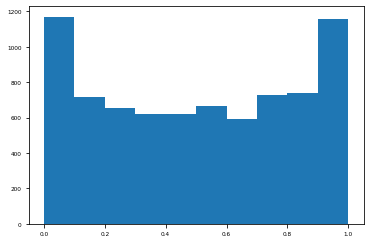

In [15]:
plt.hist(.values.reshape(-1))

In [16]:
res['corr_fdr'] = memento.util._fdrcorrect(res['corr_pval'])

In [17]:
res.query('corr_fdr < 0.1')

,gene_1,gene_2,corr_coef,corr_se,corr_pval,corr_fdr


In [22]:
g

'NONO.71294280.CTGGACAATATGCCACTCCG'

-------

In [16]:
de_pairs ={}
for g1, g2 in itertools.combinations(filtered_guides, 2):
    
    gene1, gene2 = g1.split('.')[0], g2.split('.')[0]
    shared = list(set(de_genes[g1]) & set(de_genes[g2]))
    if len(shared) > 10:
        de_pairs[g1+'-'+g2] = shared

In [17]:
len(de_pairs)

363

In [18]:
dc_results = {}
for k,v in de_pairs.items():
    
    guide1, guide2 = k.split('-')
    gene1, gene2 = guide1.split('.')[0], guide2.split('.')[0]
    
    # For g1 KO
    adata_ko = adata.copy()[
        adata.obs.guide1_cov.isin([guide1]) | \
        (adata.obs.WT=='T')].copy()
    ko_converter={'F':1, 'T':0}

    adata_ko.obs['ko_indicator'] = (adata_ko.obs['guide1_cov']==guide1).astype(int)

    memento.create_groups(adata_ko, label_columns=['ko_indicator'])
    memento.compute_1d_moments(adata_ko, min_perc_group=.7)
    
    if gene2 not in adata_ko.var.index:
        continue
    
    filtered_values = [gene for gene in v if gene in adata_ko.var.index]
    memento.compute_2d_moments(adata_ko, list(itertools.product([gene2], filtered_values)))

    meta_df = pd.get_dummies(memento.get_groups(adata_ko), drop_first=True)
    treatment = meta_df[['ko_indicator']]
    meta_df['intercept'] = 1
    covariate = meta_df[['intercept']]

    memento.ht_2d_moments(
        adata_ko, 
        covariate=covariate,
        treatment=treatment, 
        num_boot=5000, 
        verbose=1,
        num_cpus=len(filtered_values),
        resampling='bootstrap',
        resample_rep=False,
        approx=True)
    res_guide1 =  memento.get_2d_ht_result(adata_ko)
    
    # For g2 KO
    adata_ko = adata.copy()[
        adata.obs.guide1_cov.isin([guide2]) | \
        (adata.obs.WT=='T')].copy()
    ko_converter={'F':1, 'T':0}

    adata_ko.obs['ko_indicator'] = (adata_ko.obs['guide1_cov']==guide2).astype(int)

    memento.create_groups(adata_ko, label_columns=['ko_indicator'])
    memento.compute_1d_moments(adata_ko, min_perc_group=.7)
    if gene1 not in adata_ko.var.index:
        continue
    filtered_values = [gene for gene in v if gene in adata_ko.var.index]
    memento.compute_2d_moments(adata_ko, list(itertools.product([gene1], filtered_values)))

    meta_df = pd.get_dummies(memento.get_groups(adata_ko), drop_first=True)
    treatment = meta_df[['ko_indicator']]
    meta_df['intercept'] = 1
    covariate = meta_df[['intercept']]
#     covariate = meta_df.iloc[:, 1:]

    memento.ht_2d_moments(
        adata_ko, 
        covariate=covariate,
        treatment=treatment, 
        num_boot=5000, 
        verbose=1,
        num_cpus=len(filtered_values),
        resampling='bootstrap',
        resample_rep=False,
        approx=True)
    res_guide2 =  memento.get_2d_ht_result(adata_ko)
    
    res = res_guide1.merge(res_guide2, on=['gene_2'], suffixes=('_guide1', '_guide2'))
    
    dc_results[k] = res
    res['corr_fdr_guide1'] = memento.util._fdrcorrect(res['corr_pval_guide1'])
    res['corr_fdr_guide2'] = memento.util._fdrcorrect(res['corr_pval_guide2'])
    
    break
    
    print(k, res.query('corr_fdr_guide1 < 0.1').shape[0], res.query('corr_fdr_guide2 < 0.1').shape[0])
    res.to_csv(data_path + '2d_tests/{}.csv'.format(k), index=False)


[Parallel(n_jobs=43)]: Using backend LokyBackend with 43 concurrent workers.
[Parallel(n_jobs=43)]: Done  42 out of  42 | elapsed:   18.1s finished
[Parallel(n_jobs=43)]: Using backend LokyBackend with 43 concurrent workers.
[Parallel(n_jobs=43)]: Done   2 out of  43 | elapsed:    0.4s remaining:    9.0s
[Parallel(n_jobs=43)]: Done  43 out of  43 | elapsed:    3.9s finished


### Get combined differential correlation result

(array([2., 2., 8., 3., 1., 6., 0., 6., 4., 6.]),
 array([0.08638272, 0.1764847 , 0.26658668, 0.35668866, 0.44679064,
        0.53689262, 0.6269946 , 0.71709658, 0.80719856, 0.89730054,
        0.98740252]),
 <BarContainer object of 10 artists>)

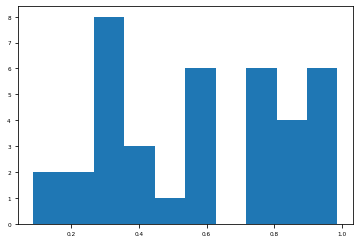

In [82]:
plt.hist(res.corr_pval_guide1)

In [115]:
res

,tx,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,de_fdr
gene,,,,,,,,
NOC2L,ko_indicator,0.022034,0.096195,8.281234e-01,0.259331,0.258825,0.317519,9.418408e-01
ISG15,ko_indicator,0.041053,0.052851,4.433301e-01,-0.779483,0.230100,0.000706,7.324655e-01
CPSF3L,ko_indicator,-0.042009,0.090263,6.513460e-01,-0.372751,0.281311,0.189568,8.573584e-01
AURKAIP1,ko_indicator,0.186313,0.074188,1.387043e-02,0.158178,0.154612,0.421769,1.023303e-01
RP4-758J18.2,ko_indicator,0.083647,0.104650,4.649185e-01,-0.896856,0.240445,0.000459,7.474997e-01
...,...,...,...,...,...,...,...,...
MT-ND4,ko_indicator,0.132163,0.017397,3.070371e-14,0.132881,0.056893,0.053288,9.236311e-11
MT-ND5,ko_indicator,0.125559,0.024470,3.352428e-07,0.078019,0.086056,0.461403,9.405655e-05
MT-ND6,ko_indicator,0.073887,0.035770,4.309970e-02,-0.216338,0.140531,0.195329,2.061459e-01


In [74]:
for k,v in dc_results.items():
    
    print(v.query('corr_pval_guide1 < 0.05 & corr_pval_guide2 < 0.05').shape)

(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)


In [38]:
len(avail_target_genes)

NameError: name 'avail_target_genes' is not defined

In [30]:
avail_guides = []
for t in avail_target_genes:
    
    for g in filtered_guides:
        if t in g:
            avail_guides.append(g)
            break

In [31]:
len(avail_guides)

76

In [32]:
heatmap = []
for guide in avail_guides:
    
    res = pd.read_csv(data_path + '1d_tests/1d_tests_{}.csv'.format(guide), index_col=0)
    res.index=res.gene
    heatmap.append(res.loc[avail_target_genes].de_coef.values)

In [33]:
heatmap = pd.DataFrame(np.vstack(heatmap), index=avail_guides, columns=avail_target_genes)

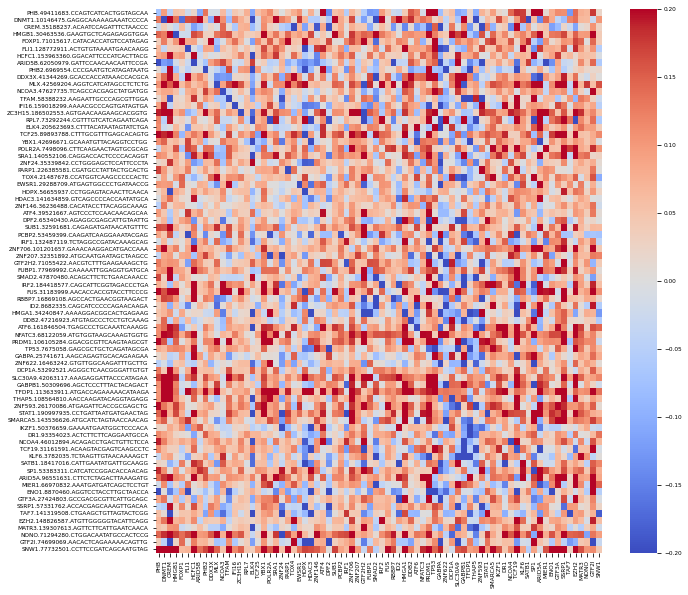

In [58]:
plt.figure(figsize=(10,10))
sns.heatmap(-1*heatmap, vmax=0.2, vmin=-0.2,xticklabels=1, yticklabels=1, center=0, cmap='coolwarm')
plt.savefig('targets.png', dpi=300)